## Homework 4

SYS 6018: Machine Learning

Caitlin Dreisbach (CND2y)

Elizabeth Homan Harrsion (EIH2NN)

Morgan Wall (MKW5CK)


In [1]:
# Load libraries
import tensorflow as tf
import cv2
import random
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/Users/eihoman/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Basic Functions:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x,name):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME',name=name)

def weight_variable(shape,varname):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=varname)


def bias_variable(shape,varname):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=varname)

In [19]:
# Build ConvNet
max_itr = 1500
def deepnn(x):
    # x is 240x240x3
    
    # First Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, 3, 16],'conv_w')
        b_conv1 = bias_variable([16],'conv_b')
        h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1,name='h_conv_op')
        h_pool1 = max_pool_2x2(h_conv1,'h_pool_op')
    # output: 120x120x16
 
    # Second Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 16, 16],'conv_w')
        b_conv2 = bias_variable([16],'conv_b')
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2,name='h_conv_op')
        h_pool2 = max_pool_2x2(h_conv2,'h_pool_op')
    # output: 60x60x16

    # Third Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([5, 5, 16, 32],'conv_w')
        b_conv3 = bias_variable([32],'conv_b')
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3,name='h_conv_op')
        h_pool3 = max_pool_2x2(h_conv3,'h_pool_op')
    # output: 30x30x32

    
    # First Fully Connected Layer
    with tf.name_scope('fc'):
        # Flatten output from previous layer
        h_pool3_flat = tf.reshape(h_pool3, [-1, 30*30*32])
        # Fully connected + Relu
        # input: flat (30x30x32) = 1x2048
        W_fc1 = weight_variable([30 * 30 * 32, 3600],'fc_w')
        b_fc1 = bias_variable([3600],'fc_b')
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
    # output: 1x3600
    
    # Dropout
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32,name="keep_prob")
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Output Softmax Layer: Map the 3600 features to 8 classes, one for each class type
    with tf.name_scope('sm'):
        W_sm = weight_variable([3600, 8],'sm_w')
        b_sm = bias_variable([8],'sm_b')
        y_conv_out = tf.add(tf.matmul(h_fc1_drop, W_sm), b_sm, name="y_conv_op")
 
    return y_conv_out,keep_prob

In [6]:
# Extra functions:
# DataSet class to handle images 
class DataSet(object):
    def __init__(self, images, labels):
        self._num_examples = len(images)
        self._images = images
        self._labels = labels
        self._epochs_done = 0
        self._index_in_epoch = 0
        np.random.seed(123456)
        # Shuffle the data
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self._images[perm]
        self._labels = self._labels[perm]
        random.seed(123456)
    @property
    def images(self):
        return self._images
    @property
    def labels(self):
        return self._labels
    @property
    def num_examples(self):
        return self._num_examples
    @property
    def epochs_done(self):
        return self._epochs_done
    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # After each epoch we update this
            self._epochs_done += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm] 
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
    
        return self._images[start:end], self._labels[start:end]

# read images from a directory
def read_images(path,images,labels,class_num,class_index):
    files = glob.glob(os.path.join(path, '*g'))
    for fl in files:
        image = cv2.imread(fl)
        image = image.astype(np.float32)
        image = np.multiply(image, 1.0 / 255.0)
        images.append(image)
        label = np.zeros(class_num)
        label[class_index] = 1.0
        labels.append(label)
    return images,labels

## Reading in image data from sub-directories

In [7]:
def read_images_from_disk(input_queue):
    """Consumes a single filename and label as a ' '-delimited string.
    Args:
      filename_and_label_tensor: A scalar string tensor.
    Returns:
      Two tensors: the decoded image, and the string label.
    """
    label = input_queue[1]
    file_contents = tf.read_file(input_queue[0])
    example = tf.image.decode_png(file_contents, channels=3)
    return example, label

In [8]:
#path1 = "/Users/caitdreisbach/Downloads/imagesML/train"

path1 = "/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train"

#path1 = "C:\\Users\\mkw5c\\Desktop\\\mona_lisa_pics\\train"

In [9]:
#get labeled directories into a list
directory_list = list()
for root, dirs, files in os.walk(path1, topdown=False):
    for name in files:
        directory_list.append(os.path.join(root, name))

print(directory_list)

['/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/f19_dfh_clx.png', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/f06_dfh_crx.png', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/m14_dfs_h.png', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/m17_dfh_crx.png', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/m08_dfh_clx.png', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/f05_dfh_clx.png', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/m19_dfs_h.png', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/S156_002_00000021.png', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/f10_dfh_clx.png', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt/m01_d

In [10]:
label_list = []
for item in directory_list:
    label_list.append(os.path.dirname(item))
print(label_list)

['/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/ima

In [11]:
#remove path prior to file name
import ntpath
ntpath.basename(path1)

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

#paths = ['/Users/caitdreisbach/Downloads/imagesML/train/contempt', 
#         '/Users/caitdreisbach/Downloads/imagesML/train/fear', 
#         '/Users/caitdreisbach/Downloads/imagesML/train/surprise', 
#         '/Users/caitdreisbach/Downloads/imagesML/train/sadness', 
#         '/Users/caitdreisbach/Downloads/imagesML/train/neutral', 
#         '/Users/caitdreisbach/Downloads/imagesML/train/happiness', 
#         '/Users/caitdreisbach/Downloads/imagesML/train/anger', 
#         '/Users/caitdreisbach/Downloads/imagesML/train/disgust']

#paths = ['/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt', 
#         '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/fear', 
#         '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/surprise', 
#         '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/sadness', 
#         '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/neutral', 
#         '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/happiness', 
#         '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/anger', 
#         '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/disgust']



alllabels = [path_leaf(path) for path in label_list]

In [12]:
print(alllabels)

['contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'contempt', 'co

In [13]:
pathimage1 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/contempt'
pathimage2 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/fear' 
pathimage3 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/surprise'
pathimage4 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/sadness' 
pathimage5 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/neutral' 
pathimage6 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/happiness'
pathimage7 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/anger'
pathimage8 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/train/disgust'

In [14]:
imagestest = []
labelstest = []
x = read_images(pathimage1,imagestest,labelstest,1,0)
print(len(x[1]))
imagestest = []
labelstest = []
x = read_images(pathimage2,imagestest,labelstest,1,0)
print(len(x[1]))
imagestest = []
labelstest = []
x = read_images(pathimage3,imagestest,labelstest,1,0)
print(len(x[1]))
imagestest = []
labelstest = []
x = read_images(pathimage4,imagestest,labelstest,1,0)
print(len(x[1]))
imagestest = []
labelstest = []
x = read_images(pathimage5,imagestest,labelstest,1,0)
print(len(x[1]))
imagestest = []
labelstest = []
x = read_images(pathimage6,imagestest,labelstest,1,0)
print(len(x[1]))
imagestest = []
labelstest = []
x = read_images(pathimage7,imagestest,labelstest,1,0)
print(len(x[1]))
imagestest = []
labelstest = []
x = read_images(pathimage8,imagestest,labelstest,1,0)
print(len(x[1]))

115
123
184
138
610
177
135
153


Reading images
Finished reading images


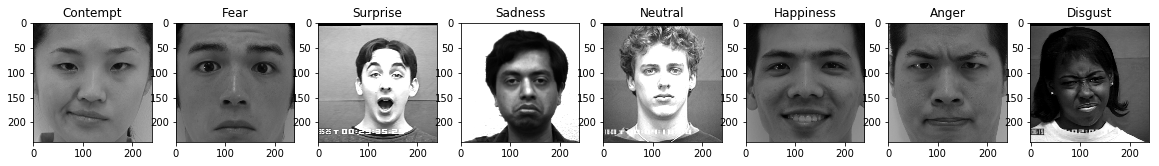

In [15]:
# load images
images = []
labels = []

print('Reading images')
images,labels=read_images(pathimage1,images,labels,8,0)
images,labels=read_images(pathimage2,images,labels,8,1)
images,labels=read_images(pathimage3,images,labels,8,2)
images,labels=read_images(pathimage4,images,labels,8,3)
images,labels=read_images(pathimage5,images,labels,8,4)
images,labels=read_images(pathimage6,images,labels,8,5)
images,labels=read_images(pathimage7,images,labels,8,6)
images,labels=read_images(pathimage8,images,labels,8,7)
print('Finished reading images') 

images = np.array(images)
labels = np.array(labels)

# Create dataset
train = DataSet(images, labels)

# parameters
model_dir="model_Mona_Lisa"
image_size=240

# Inspect Data: Show first image of each type
fig = plt.figure(figsize=(20, 20)) 

ax = fig.add_subplot(181)
plt.imshow(images[0])
ax.set_title('Contempt')  

ax = fig.add_subplot(182)
plt.imshow(images[120])
ax.set_title('Fear')

ax = fig.add_subplot(183)
plt.imshow(images[245])
ax.set_title('Surprise')

ax = fig.add_subplot(184)
plt.imshow(images[440])
ax.set_title('Sadness')

ax = fig.add_subplot(185)
plt.imshow(images[575])
ax.set_title('Neutral')

ax = fig.add_subplot(186)
plt.imshow(images[1202])
ax.set_title('Happiness')

ax = fig.add_subplot(187)
plt.imshow(images[1350])
ax.set_title('Anger')

ax = fig.add_subplot(188)
plt.imshow(images[1490])
ax.set_title('Disgust')

plt.show()

In [16]:
labels.shape


(1635, 8)

## Create computational graph 

In [20]:
# ******** Cell - 1 ***********
graph = tf.Graph()
with graph.as_default():   
    # Create the computational graph:
    # Placeholders:
    x = tf.placeholder(tf.float32, [None, image_size,image_size,3],name="x")
    y = tf.placeholder(tf.float32, [None, 8],name="y")
    print(y.shape)
    # Build the graph for the deep net
    y_conv_out,keep_prob = deepnn(x)

    
    batch_size = tf.shape(x)[0]
    #y_manip = tf.reshape(y_conv_out, [batch_size, 8])
    
    print(y_conv_out.shape)
    # Add loss, accuracy and optimization
    probs=tf.nn.softmax(logits=y_conv_out, name="probs_op")
    
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=y_conv_out)
        cross_entropy = tf.reduce_mean(cross_entropy)
    
    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv_out, 1), tf.argmax(y, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction, name="acc_op")
        
    # Add a saver to save the trained model
    saver = tf.train.Saver() 

(?, 8)
(?, 8)


In [21]:
# ******** Cell - 2 ***********
# Reset graph: useful for multiple runs (e.g., parameter tuning, CV, etc.)
tf.reset_default_graph()  
# Create session to execute graph
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(max_itr):
        # Save a version of the model every 100 iterations - NOT DOING THIS - TAKES TOO MUCH MEMORY SPACE
        #if i>0 and i%100==0:
        #    saver.save(sess, "./%s/model"%(model_dir), global_step=i)
            
        # Get a batch of 32 images    
        x_batch, y_true_batch = train.next_batch(32) 
        #print(x_batch.shape, y_true_batch.shape)
        
        # Get training accuracy on the batch
        if i>0 and i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: x_batch , y: y_true_batch, keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
            
        # Train
        train_step.run(feed_dict={x: x_batch, y: y_true_batch, keep_prob: 0.5})
        
    # save final model
    save_path = saver.save(sess, "./%s/model"%(model_dir), global_step=max_itr)
    print("Model saved in file: %s" % save_path)
    
    # Get training accuracy on all training images
    train_accuracy=accuracy.eval(feed_dict={x: images,y: labels, keep_prob: 1.0 })
    print ("Training Accuracy: %10.5f"%train_accuracy)

step 100, training accuracy 0.59375
step 200, training accuracy 0.46875
step 300, training accuracy 0.65625
step 400, training accuracy 0.65625
step 500, training accuracy 0.625
step 600, training accuracy 0.78125
step 700, training accuracy 0.75
step 800, training accuracy 0.8125
step 900, training accuracy 0.90625
step 1000, training accuracy 0.96875
step 1100, training accuracy 0.9375
step 1200, training accuracy 0.90625
step 1300, training accuracy 0.9375
step 1400, training accuracy 1
Model saved in file: ./model_Mona_Lisa/model-1500
Training Accuracy:    0.98043


In [22]:
pathimage11 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/valid/contempt'
pathimage22 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/valid/fear' 
pathimage33 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/valid/surprise'
pathimage44 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/valid/sadness' 
pathimage55 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/valid/neutral' 
pathimage66 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/valid/happiness'
pathimage77 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/valid/anger'
pathimage88 = '/Users/eihoman/Desktop/DSI/Machine Learning/hw/Assignment 4/images/valid/disgust'

In [23]:
# Load testing images
test_images = []   
test_labels = []   

print('Reading testing images')
test_images,test_labels=read_images(pathimage11,test_images,test_labels,8,0)
test_images,test_labels=read_images(pathimage22,test_images,test_labels,8,1)
test_images,test_labels=read_images(pathimage33,test_images,test_labels,8,2)
test_images,test_labels=read_images(pathimage44,test_images,test_labels,8,3)
test_images,test_labels=read_images(pathimage55,test_images,test_labels,8,4)
test_images,test_labels=read_images(pathimage66,test_images,test_labels,8,5)
test_images,test_labels=read_images(pathimage77,test_images,test_labels,8,6)
test_images,test_labels=read_images(pathimage88,test_images,test_labels,8,7)
print('Finished reading testing images') 

test_images = np.array(test_images)
test_labels = np.array(test_labels)

#y_new = np.zeros(8)
#y_newer = y_new.reshape(1,8)
#test_labels = y_newer

Reading testing images
Finished reading testing images


In [24]:
# ******** Cell - 3 ***********
# Test model on testing data
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('./%s/model-%s.meta'%(model_dir,max_itr))
    saver.restore(sess,tf.train.latest_checkpoint(model_dir))
    graph = tf.get_default_graph()
    
    #print([n.name for n in tf.get_default_graph().as_graph_def().node])
     
    x = graph.get_tensor_by_name("x:0")
    y = graph.get_tensor_by_name("y:0")
    keep_prob= graph.get_tensor_by_name("dropout/keep_prob:0") 
    accuracy = graph.get_tensor_by_name("accuracy/acc_op:0")
    
    acc_val=accuracy.eval(feed_dict={x: test_images,y: test_labels, keep_prob: 1.0 })
    print ("Testing Accuracy: %10.5f"%acc_val)
    
    prediction=tf.argmax(y,1)
    print (prediction.eval(feed_dict={x: test_images}))

INFO:tensorflow:Restoring parameters from model_Mona_Lisa/model-1500
Testing Accuracy:    0.72881
